# Predicting Tomorrow's Temperature in Tampa, Florida

Our objective is to predict tomorrow's temperature given x number of previous days temperatures. 

Our model, therefore, must accept x number of features -- each of which as the measures of temperatures, in sequence, over the past x days

To get our data, go to https://climatecenter.fsu.edu/climate-data-access-tools/downloadable-data and download weather data for the past 51 years. Select Tampa for the data set, and mean temperature as the value. Downlown this data (it will be in csv format) and store it in your working directory (the directory this notebook is in).


The following sequence of code will prepare our data for analysis.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)

## Collect and prepare data for analysis

In [30]:
df = pd.read_csv('./data/TampaTemps.csv',  parse_dates=True)

In [31]:
df.columns

Index(['COOPID', ' YEAR', ' MONTH', ' DAY', ' meanTemp'], dtype='object')

In [32]:
df = df[[' meanTemp']]  # watch the spaces in the column name 

In [33]:
df

,meanTemp
0,49.5
1,51.5
2,64.0
3,74.0
4,72.0
...,...
19020,54.0
19021,61.5
19022,68.0
19023,71.0


In [34]:
df[' meanTemp'].isna().sum()

0

In [35]:
row_count = df.shape[0] # store the number of obersvations (daily temperature readings)
row_count

19025

In [36]:
temps = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of temperatures
temps.shape

(19025, 1)

In [37]:
sequence_length = 60  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [38]:
temps = temps[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
temps.shape

(19020, 1)

In [39]:
temps = temps.reshape(row_count // sequence_length, sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
temps

array([[73.5, 61.5, 67.5, ..., 66.5, 50.5, 53. ],
       [61. , 57. , 49. , ..., 72. , 71.5, 65.5],
       [67. , 75. , 72.5, ..., 82.5, 82. , 81.5],
       ...,
       [87.5, 88. , 87. , ..., 86.5, 84.5, 82. ],
       [84.5, 86.5, 87. , ..., 79. , 78. , 80. ],
       [83. , 79.5, 76.5, ..., 68. , 71. , 68.5]])

In [40]:
# we can now see that our days have been organized into rows of sequence length. 

In [41]:
# create our X and y. 
# X will be the 59 days prior...
X = temps[:, :-1] # all rows, all columns except the last one
# y will be the 60th day (what we are trying to predict)
y = temps[:, -1] # all rows, only the last column

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [43]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(221, 59, 1)
(96, 59, 1)


In [44]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [45]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
7/7 [==============================] - 3s 65ms/step - loss: 5767.4370 - root_mean_squared_error: 75.9436 - val_loss: 5667.7700 - val_root_mean_squared_error: 75.2846
Epoch 2/600
7/7 [==============================] - 0s 21ms/step - loss: 5651.7036 - root_mean_squared_error: 75.1778 - val_loss: 5543.3906 - val_root_mean_squared_error: 74.4539
Epoch 3/600
7/7 [==============================] - 0s 20ms/step - loss: 5530.2490 - root_mean_squared_error: 74.3656 - val_loss: 5422.0273 - val_root_mean_squared_error: 73.6344
Epoch 4/600
7/7 [==============================] - 0s 20ms/step - loss: 5404.3613 - root_mean_squared_error: 73.5144 - val_loss: 5296.0317 - val_root_mean_squared_error: 72.7738
Epoch 5/600
7/7 [==============================] - 0s 22ms/step - loss: 5276.1182 - root_mean_squared_error: 72.6369 - val_loss: 5147.7427 - val_root_mean_squared_error: 71.7478
Epoch 6/600
7/7 [==============================] - 0s 23ms/step - loss: 5111.0425 - root_mean_squared_error: 7

Epoch 47/600
7/7 [==============================] - 0s 17ms/step - loss: 2626.7898 - root_mean_squared_error: 51.2522 - val_loss: 2578.1426 - val_root_mean_squared_error: 50.7754
Epoch 48/600
7/7 [==============================] - 0s 17ms/step - loss: 2587.9675 - root_mean_squared_error: 50.8721 - val_loss: 2540.0627 - val_root_mean_squared_error: 50.3990
Epoch 49/600
7/7 [==============================] - 0s 17ms/step - loss: 2549.8708 - root_mean_squared_error: 50.4962 - val_loss: 2502.3850 - val_root_mean_squared_error: 50.0238
Epoch 50/600
7/7 [==============================] - 0s 17ms/step - loss: 2512.2390 - root_mean_squared_error: 50.1222 - val_loss: 2465.0991 - val_root_mean_squared_error: 49.6498
Epoch 51/600
7/7 [==============================] - 0s 16ms/step - loss: 2474.7002 - root_mean_squared_error: 49.7464 - val_loss: 2428.4241 - val_root_mean_squared_error: 49.2790
Epoch 52/600
7/7 [==============================] - 0s 17ms/step - loss: 2438.2273 - root_mean_squared_er

Epoch 93/600
7/7 [==============================] - 0s 17ms/step - loss: 1267.8998 - root_mean_squared_error: 35.6076 - val_loss: 1236.6566 - val_root_mean_squared_error: 35.1661
Epoch 94/600
7/7 [==============================] - 0s 17ms/step - loss: 1246.7527 - root_mean_squared_error: 35.3094 - val_loss: 1215.7112 - val_root_mean_squared_error: 34.8671
Epoch 95/600
7/7 [==============================] - 0s 17ms/step - loss: 1225.6143 - root_mean_squared_error: 35.0088 - val_loss: 1195.2104 - val_root_mean_squared_error: 34.5718
Epoch 96/600
7/7 [==============================] - 0s 16ms/step - loss: 1205.1774 - root_mean_squared_error: 34.7157 - val_loss: 1174.8632 - val_root_mean_squared_error: 34.2763
Epoch 97/600
7/7 [==============================] - 0s 16ms/step - loss: 1184.7551 - root_mean_squared_error: 34.4203 - val_loss: 1154.8704 - val_root_mean_squared_error: 33.9834
Epoch 98/600
7/7 [==============================] - 0s 16ms/step - loss: 1164.8649 - root_mean_squared_er

Epoch 139/600
7/7 [==============================] - 0s 17ms/step - loss: 563.3433 - root_mean_squared_error: 23.7349 - val_loss: 544.6176 - val_root_mean_squared_error: 23.3370
Epoch 140/600
7/7 [==============================] - 0s 16ms/step - loss: 553.2542 - root_mean_squared_error: 23.5214 - val_loss: 534.6657 - val_root_mean_squared_error: 23.1228
Epoch 141/600
7/7 [==============================] - 0s 16ms/step - loss: 543.1504 - root_mean_squared_error: 23.3056 - val_loss: 524.9039 - val_root_mean_squared_error: 22.9108
Epoch 142/600
7/7 [==============================] - 0s 16ms/step - loss: 533.3215 - root_mean_squared_error: 23.0938 - val_loss: 515.3582 - val_root_mean_squared_error: 22.7015
Epoch 143/600
7/7 [==============================] - 0s 17ms/step - loss: 523.7249 - root_mean_squared_error: 22.8850 - val_loss: 505.9071 - val_root_mean_squared_error: 22.4924
Epoch 144/600
7/7 [==============================] - 0s 16ms/step - loss: 514.1457 - root_mean_squared_error: 

7/7 [==============================] - 0s 16ms/step - loss: 244.9524 - root_mean_squared_error: 15.6510 - val_loss: 235.0887 - val_root_mean_squared_error: 15.3326
Epoch 186/600
7/7 [==============================] - 0s 16ms/step - loss: 240.7736 - root_mean_squared_error: 15.5169 - val_loss: 231.2412 - val_root_mean_squared_error: 15.2066
Epoch 187/600
7/7 [==============================] - 0s 16ms/step - loss: 236.3584 - root_mean_squared_error: 15.3740 - val_loss: 226.9400 - val_root_mean_squared_error: 15.0645
Epoch 188/600
7/7 [==============================] - 0s 16ms/step - loss: 232.1559 - root_mean_squared_error: 15.2367 - val_loss: 223.2344 - val_root_mean_squared_error: 14.9410
Epoch 189/600
7/7 [==============================] - 0s 16ms/step - loss: 228.1469 - root_mean_squared_error: 15.1045 - val_loss: 218.9910 - val_root_mean_squared_error: 14.7983
Epoch 190/600
7/7 [==============================] - 0s 14ms/step - loss: 224.2054 - root_mean_squared_error: 14.9735 - val_

7/7 [==============================] - 0s 18ms/step - loss: 108.5918 - root_mean_squared_error: 10.4207 - val_loss: 104.3466 - val_root_mean_squared_error: 10.2150
Epoch 232/600
7/7 [==============================] - 0s 18ms/step - loss: 106.7233 - root_mean_squared_error: 10.3307 - val_loss: 102.5760 - val_root_mean_squared_error: 10.1280
Epoch 233/600
7/7 [==============================] - 0s 18ms/step - loss: 104.9035 - root_mean_squared_error: 10.2422 - val_loss: 100.6941 - val_root_mean_squared_error: 10.0346
Epoch 234/600
7/7 [==============================] - 0s 17ms/step - loss: 103.2522 - root_mean_squared_error: 10.1613 - val_loss: 99.0019 - val_root_mean_squared_error: 9.9500
Epoch 235/600
7/7 [==============================] - 0s 16ms/step - loss: 101.4204 - root_mean_squared_error: 10.0708 - val_loss: 97.3596 - val_root_mean_squared_error: 9.8671
Epoch 236/600
7/7 [==============================] - 0s 17ms/step - loss: 99.7432 - root_mean_squared_error: 9.9872 - val_loss: 

7/7 [==============================] - 0s 16ms/step - loss: 50.3025 - root_mean_squared_error: 7.0924 - val_loss: 48.4760 - val_root_mean_squared_error: 6.9625
Epoch 279/600
7/7 [==============================] - 0s 16ms/step - loss: 49.3439 - root_mean_squared_error: 7.0245 - val_loss: 47.3679 - val_root_mean_squared_error: 6.8824
Epoch 280/600
7/7 [==============================] - 0s 17ms/step - loss: 48.5845 - root_mean_squared_error: 6.9703 - val_loss: 46.4233 - val_root_mean_squared_error: 6.8135
Epoch 281/600
7/7 [==============================] - 0s 16ms/step - loss: 47.8839 - root_mean_squared_error: 6.9198 - val_loss: 45.5116 - val_root_mean_squared_error: 6.7462
Epoch 282/600
7/7 [==============================] - 0s 17ms/step - loss: 47.0981 - root_mean_squared_error: 6.8628 - val_loss: 45.1070 - val_root_mean_squared_error: 6.7162
Epoch 283/600
7/7 [==============================] - 0s 16ms/step - loss: 46.4782 - root_mean_squared_error: 6.8175 - val_loss: 44.4254 - val_ro

7/7 [==============================] - 0s 17ms/step - loss: 25.8391 - root_mean_squared_error: 5.0832 - val_loss: 25.3951 - val_root_mean_squared_error: 5.0394
Epoch 326/600
7/7 [==============================] - 0s 16ms/step - loss: 25.5086 - root_mean_squared_error: 5.0506 - val_loss: 24.7838 - val_root_mean_squared_error: 4.9783
Epoch 327/600
7/7 [==============================] - 0s 16ms/step - loss: 25.1925 - root_mean_squared_error: 5.0192 - val_loss: 24.2036 - val_root_mean_squared_error: 4.9197
Epoch 328/600
7/7 [==============================] - 0s 16ms/step - loss: 24.8663 - root_mean_squared_error: 4.9866 - val_loss: 24.0242 - val_root_mean_squared_error: 4.9015
Epoch 329/600
7/7 [==============================] - 0s 17ms/step - loss: 24.4892 - root_mean_squared_error: 4.9487 - val_loss: 24.2448 - val_root_mean_squared_error: 4.9239
Epoch 330/600
7/7 [==============================] - 0s 16ms/step - loss: 24.3564 - root_mean_squared_error: 4.9352 - val_loss: 23.7365 - val_ro

7/7 [==============================] - 0s 18ms/step - loss: 14.7885 - root_mean_squared_error: 3.8456 - val_loss: 16.9631 - val_root_mean_squared_error: 4.1186
Epoch 373/600
7/7 [==============================] - 0s 17ms/step - loss: 14.7022 - root_mean_squared_error: 3.8343 - val_loss: 17.1162 - val_root_mean_squared_error: 4.1372
Epoch 374/600
7/7 [==============================] - 0s 17ms/step - loss: 14.4887 - root_mean_squared_error: 3.8064 - val_loss: 17.0235 - val_root_mean_squared_error: 4.1260
Epoch 375/600
7/7 [==============================] - 0s 17ms/step - loss: 14.3492 - root_mean_squared_error: 3.7880 - val_loss: 16.5305 - val_root_mean_squared_error: 4.0658
Epoch 376/600
7/7 [==============================] - 0s 16ms/step - loss: 14.1786 - root_mean_squared_error: 3.7654 - val_loss: 16.1417 - val_root_mean_squared_error: 4.0177
Epoch 377/600
7/7 [==============================] - 0s 17ms/step - loss: 14.0951 - root_mean_squared_error: 3.7543 - val_loss: 16.4208 - val_ro

7/7 [==============================] - 0s 18ms/step - loss: 9.7793 - root_mean_squared_error: 3.1272 - val_loss: 12.6929 - val_root_mean_squared_error: 3.5627
Epoch 420/600
7/7 [==============================] - 0s 18ms/step - loss: 9.7365 - root_mean_squared_error: 3.1203 - val_loss: 12.7506 - val_root_mean_squared_error: 3.5708
Epoch 421/600
7/7 [==============================] - 0s 16ms/step - loss: 9.4230 - root_mean_squared_error: 3.0697 - val_loss: 12.5201 - val_root_mean_squared_error: 3.5384
Epoch 422/600
7/7 [==============================] - 0s 17ms/step - loss: 9.2909 - root_mean_squared_error: 3.0481 - val_loss: 12.5232 - val_root_mean_squared_error: 3.5388
Epoch 423/600
7/7 [==============================] - 0s 17ms/step - loss: 9.2155 - root_mean_squared_error: 3.0357 - val_loss: 12.7343 - val_root_mean_squared_error: 3.5685
Epoch 424/600
7/7 [==============================] - 0s 19ms/step - loss: 9.2439 - root_mean_squared_error: 3.0404 - val_loss: 12.2376 - val_root_mea

7/7 [==============================] - 0s 18ms/step - loss: 6.9582 - root_mean_squared_error: 2.6378 - val_loss: 12.1457 - val_root_mean_squared_error: 3.4851
Epoch 467/600
7/7 [==============================] - 0s 17ms/step - loss: 6.8064 - root_mean_squared_error: 2.6089 - val_loss: 12.2116 - val_root_mean_squared_error: 3.4945
Epoch 468/600
7/7 [==============================] - 0s 17ms/step - loss: 6.6391 - root_mean_squared_error: 2.5766 - val_loss: 12.2962 - val_root_mean_squared_error: 3.5066
Epoch 469/600
7/7 [==============================] - 0s 18ms/step - loss: 6.7749 - root_mean_squared_error: 2.6029 - val_loss: 12.2337 - val_root_mean_squared_error: 3.4977
Epoch 470/600
7/7 [==============================] - 0s 17ms/step - loss: 6.5407 - root_mean_squared_error: 2.5575 - val_loss: 12.8365 - val_root_mean_squared_error: 3.5828
Epoch 471/600
7/7 [==============================] - 0s 17ms/step - loss: 6.7027 - root_mean_squared_error: 2.5889 - val_loss: 11.8113 - val_root_mea

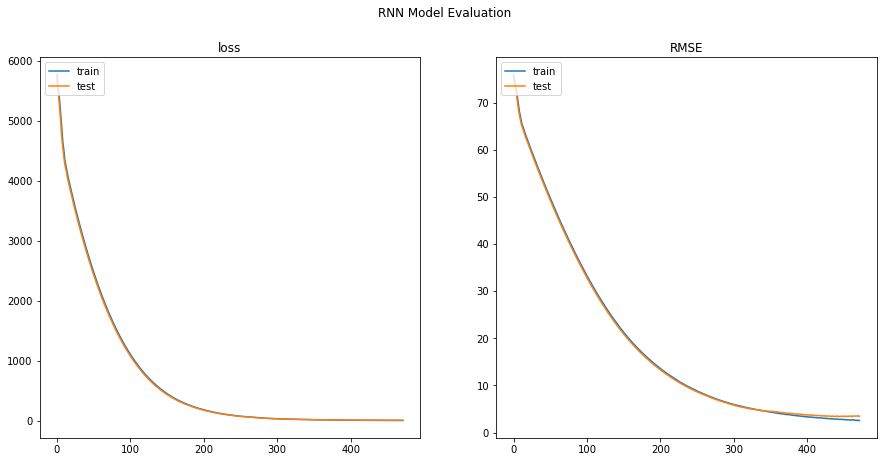

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [48]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


3/3 [==============================] - 0s 6ms/step


3.473932290356739

Now, let's say our past 59 days of temperatures were as follow....

In [24]:
prior_days = np.array(
    [
        77,75,79,85,78,75,81,83,87,80, 
        76,72,81,82,79,78,82,80,81,81, 
        74,76,82,83,75,77,83,81,83,80, 
        79,77,78,84,76,76,82,83,85,83, 
        76,74,79,85,77,72,83,82,83,84, 
        78,77,80,81,78,74,81,84,87, 
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 59, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [25]:
model.predict(prior_days) # note the structure of the prediction

1/1 [==============================] - 0s 151ms/step


array([[80.68383]], dtype=float32)

In [26]:
tomorrows_temp = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 24ms/step


In [27]:
print(f"Tomorrow's predicted temperature is {tomorrows_temp:.2f} degrees Fahrenheit.")

Tomorrow's predicted temperature is 80.68 degrees Fahrenheit.
